In [1]:
%pip install qdrant-client

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import PointStruct

import pandas as pd
from PIL import Image, PngImagePlugin
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import torchvision
import pytorch_lightning as pl
import torch
from torch import nn

PngImagePlugin.MAX_TEXT_CHUNK = int(1e15)

qdrant_client = QdrantClient(path="../database")
collection_name = "image_embeddings2"

qdrant_client.recreate_collection(
    collection_name=collection_name,
    vectors_config=models.VectorParams(size=512, distance=models.Distance.COSINE)
)

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/tmp/ipykernel_5256/1969650070.py:18: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant_client.recreate_collection(


True

In [3]:
df = pd.read_parquet('../new_data30k.parquet.gzip')
df.head(3)

,Img_url,Img_path,Img_folder,name,items,date,place,size,description,interval_start,interval_end,time_accuracy,typology,class
0,https://goskatalog.ru/muzfo-imaginator/rest/im...,00000.png,images_path10k,Распоряжение. № 39 по Осинскому горсовету.,"[чернила, машинопись, рукопись, бумага]",2.03.1937 г.,"Свердловская обл., г. Оса","8,8х22,1 см",Машинописный текст (копийный экземпляр). Содер...,1937-01-01T12:00:00.000Z,None,YEAR,документы,11
1,https://goskatalog.ru/muzfo-imaginator/rest/im...,00001.png,images_path10k,Фото черно-белое. Марков С.С. и Звягина Н.А. -...,"[фотобумага, фотопечать]",1963 г.,г. Барнаул,9х10 см,На снимке запечатлены в новой студии на Змеино...,None,None,YEAR,фотографии и негативы,13
2,https://goskatalog.ru/muzfo-imaginator/rest/im...,00002.png,images_path10k,Погон рядового Учебно-автомобильной роты.,"[тесьма, краска, шитье, сукно]",1914,Россия,"15,5 х 6 см.","Двусторонний, из алого и защитного сукна, обши...",1914-01-01T12:00:00.000Z,1917-01-01T12:00:00.000Z,YEAR,прочие,8


In [4]:
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = df.iloc[[idx]]
        img = Image.open(f"/home/jupyter/datasphere/project/{row['Img_folder'].iloc[0]}/{row['Img_path'].iloc[0]}")
        extra_info = row.to_dict('records')[0]
        if self.transform:
            img = self.transform(img)
        return img, {"index":idx, 'class':extra_info['class']}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
import torchvision
from torchmetrics.classification import Accuracy

class ImageClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(weights="DEFAULT")
        self.model.fc = nn.Linear(self.model.fc.in_features, 15)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=15)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=15)
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        accuracy = self.accuracy(outputs, labels)
        logs = {'loss': loss, 'accuracy': accuracy}
        self.log_dict(logs, logger=True)
        return logs
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels.view(-1))
        accuracy = self.val_accuracy(outputs, labels)
        logs = {"val_loss": loss, "val_accuracy": accuracy}
        self.log_dict(logs, logger=True)
        return logs

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [9]:
BATCH_SIZE = 128

dataset = ImageDataset(df, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

In [ ]:
for idx, (images, extra_info) in enumerate(dataloader):
    images = images.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    print(extra_info["index"][0].item())
    points = [
        PointStruct(
            id=extra_info["index"][i].item(), 
            vector=[0] * 512,
            payload={
                "index": extra_info["index"][i].item(),
                "class": extra_info["class"][i].item(),
            }
        )
        for i, embedding in enumerate(images)
    ]
    #qdrant_client.upsert(collection_name=collection_name, points=points)

In [11]:
from tqdm import tqdm

def upsert_embeddings(model, dataloader):
    model.eval()
    with torch.no_grad():
        for idx, (images, extra_info) in enumerate(tqdm(dataloader)):
            images = images.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            embeddings = model(images).cpu().numpy()
            points = [
                PointStruct(
                    id=extra_info["index"][i].item(), 
                    vector=embedding.tolist(),
                    payload={
                        "index": extra_info["index"][i].item(),
                        "class": extra_info["class"][i].item(),
                    }
                )
                for i, embedding in enumerate(embeddings)
            ]
            qdrant_client.upsert(collection_name=collection_name, points=points)

class ResNetEmbeddings(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model.model
        self.model.fc = nn.Identity()

    def forward(self, x):
        return self.model(x)

checkpoint_path = "/home/jupyter/datasphere/project/MODEL/double_learn_logs/resnet/version_4/checkpoints/epoch=4-step=200.ckpt"
trained_model = ImageClassifier.load_from_checkpoint(checkpoint_path)
trained_model.eval()
embedding_model = ResNetEmbeddings(trained_model).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

upsert_embeddings(embedding_model, dataloader)

def get_similar_images(query_image_path, top_k=5):
    query_image = Image.open(query_image_path)
    query_image = transform(query_image).unsqueeze(0).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    with torch.no_grad():
        query_embedding = embedding_model(query_image).cpu().numpy()[0]

    results = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_embedding.tolist(),
        limit=top_k
    )

    similar_images = [df.iloc[point.payload["index"]]["Img_folder"] + "/" + df.iloc[point.payload["index"]]["Img_path"] for point in results]
    return similar_images


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 14.0MB/s]
100%|██████████| 211/211 [16:34<00:00,  4.71s/it]


In [12]:
from PIL import Image

In [55]:
imgs = get_similar_images(f"/home/jupyter/datasphere/project/testing/6059.JPG", 10)

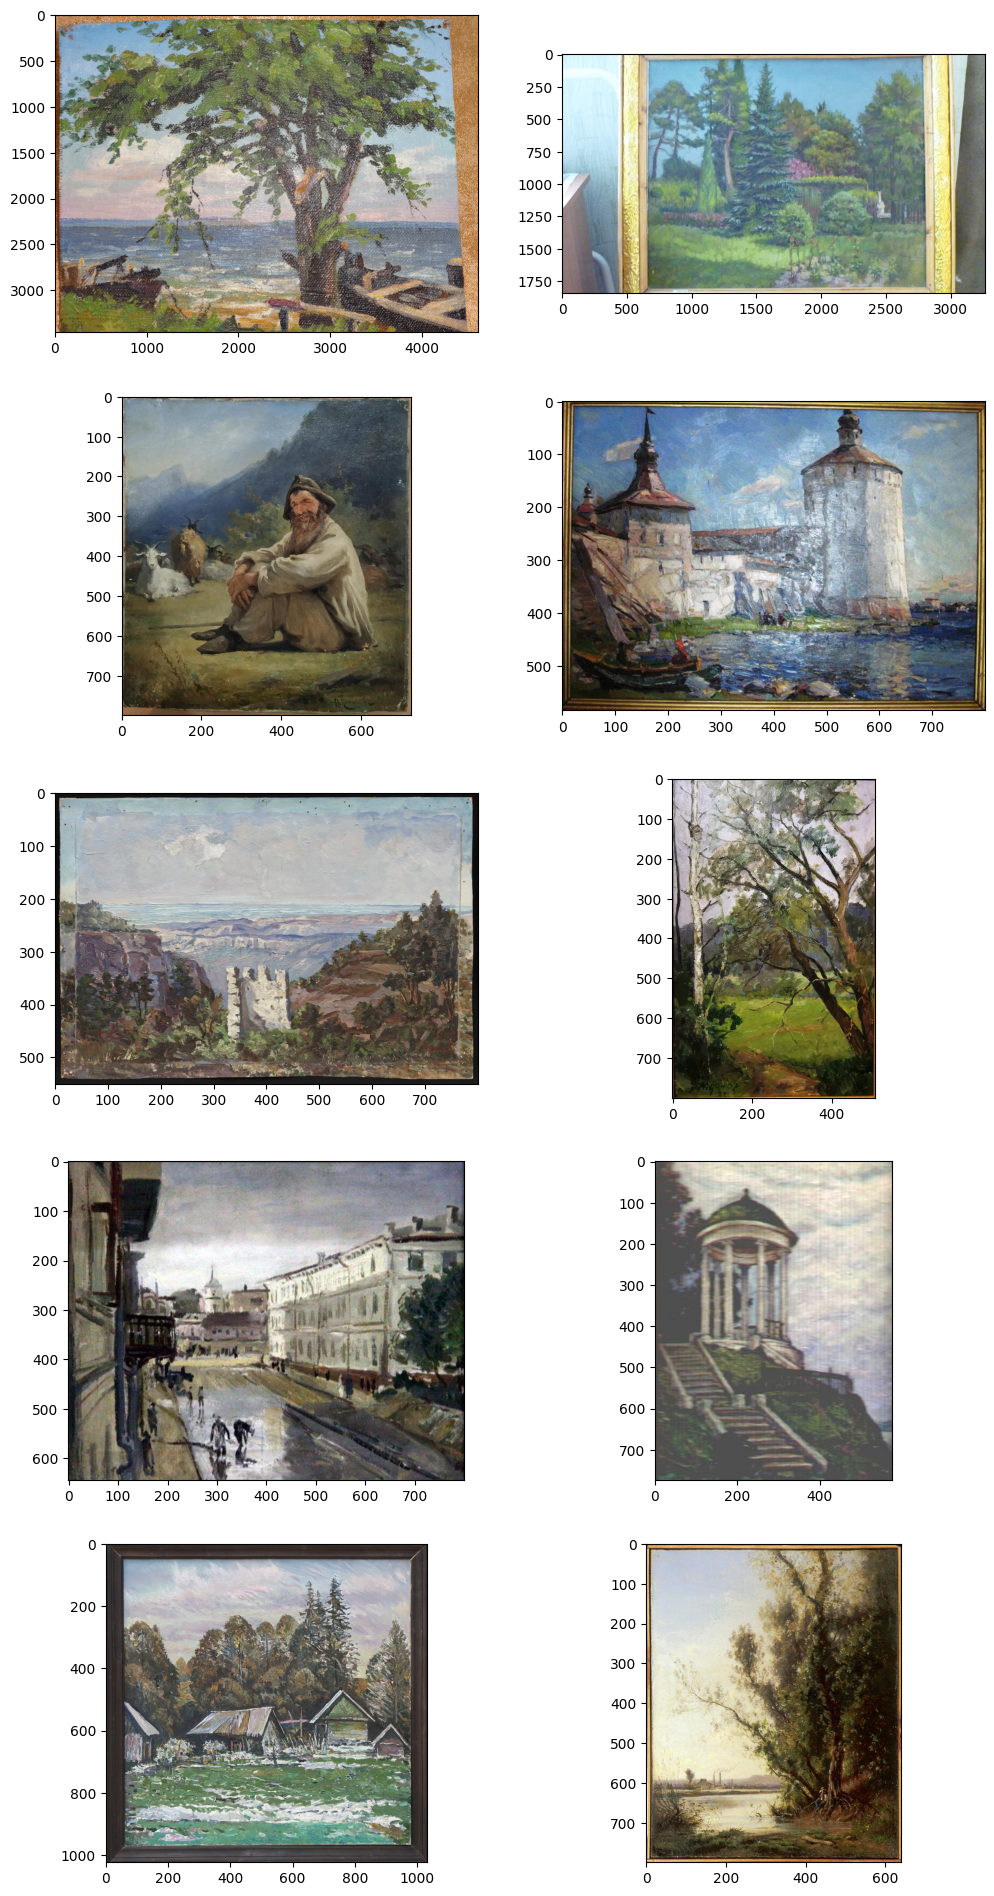

In [56]:
import matplotlib.pyplot as plt
_, axs = plt.subplots(5, 2, figsize=(12, 24))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(Image.open('../' + img))
plt.show()
